# Medium Articles EDA

In this kernel `intense EDA` is performed on [Medium Articles](https://www.kaggle.com/hsankesara/medium-articles) by [Hsankesara](https://www.kaggle.com/hsankesara) where he dataset contains `articles`, their `title`, `number of claps` it has received, their `links` and their `reading time`.

**While doing this we'll go through:**
- Preprocessing of text data
- Removing outliers using `IQR` and `z-score` methods
- Data visualization using `seaborn` and `word cloud`
- Building `classes` following the `DRY` convention

During `EDA` we'll use the preprocessed data to answer different questions.

![](https://media.giphy.com/media/5zf2M4HgjjWszLd4a5/giphy.gif)

In [1]:
import re
import math
import string
from random import randint

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import zscore
from nltk.corpus import stopwords
from wordcloud import STOPWORDS, WordCloud

from sklearn.preprocessing import MinMaxScaler

In [2]:
# Loading dataset
df = pd.read_csv('/kaggle/input/medium-articles/articles.csv')
df.sample(5)

,author,claps,reading_time,link,title,text
40,Pinterest Engineering,113,6,https://medium.com/@Pinterest_Engineering/buil...,Building a smarter home feed – Pinterest Engin...,"Chris Pinchak | Pinterest engineer, Discovery\..."
123,Denny Vrandečić,4,4,https://medium.com/@vrandezo/ai-is-coming-and-...,"AI is coming, and it will be boring – Denny Vr...","I was asked about my opinion on this topic, an..."
129,Matt O'Leary,373,12,https://howwegettonext.com/i-let-ibm-s-robot-c...,I Let IBM’s Robot Chef Tell Me What to Cook fo...,Originally published at www.howwegettonext.com...
25,Netflix Technology Blog,365,10,https://medium.com/netflix-techblog/netflix-re...,Netflix Recommendations: Beyond the 5 stars (P...,by Xavier Amatriain and Justin Basilico (Perso...
267,Maruti Techlabs,552,5,https://chatbotsmagazine.com/which-are-the-bes...,What Are The Best Intelligent Chatbots or AI C...,How do we define the intelligence of a chatbot...


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 337 entries, 0 to 336
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   author        337 non-null    object
 1   claps         337 non-null    object
 2   reading_time  337 non-null    int64 
 3   link          337 non-null    object
 4   title         337 non-null    object
 5   text          337 non-null    object
dtypes: int64(1), object(5)
memory usage: 15.9+ KB


No missing data

`CustomFormatter` class will have helper functions to format strings, just for `extra touch` 🍷.

In [4]:
# Formatter to format anything
class CustomFormatter:
    def __init__(self):
        pass
    
    # convert number to K 
    # eg. 1,000 to 1K
    # can't think of any better name for this func
    @staticmethod
    def format_likes_number_to_str(number):
        rounded_num = round(number / 1000, 2)
        frac, whole = math.modf(rounded_num)
        frac = round(frac, 2) if frac != 0 else 0
        return f'{int(whole) + frac}K'

    
print(CustomFormatter.format_likes_number_to_str(5000))
print(CustomFormatter.format_likes_number_to_str(5200))

5K
5.2K


## Data Preparation

Here we are going to clean the data known as `data cleaning` process and transform it for use know `data wrangling` process.

> Data cleaning focuses on removing inaccurate data from your data set whereas data wrangling focuses on transforming the data's format, typically by converting “raw” data into another format more suitable for use.

Convert `claps` dtype from str to int.

In [5]:
def convert_clap_dtype(clap_str):
    if 'K' not in clap_str:
        # 32
        return int(clap_str)
    if 'K' in clap_str:
        # 32K & 3.2K
        return int(float(clap_str.split('K')[0]) * 1000)
    print(f'🌊 Anomaly: {clap_str}')
    return clap_str


df.claps = df.claps.apply(convert_clap_dtype)
df.claps.values[:10].tolist()

[8300, 1400, 2800, 1300, 935, 2000, 2300, 252, 937, 2300]

Creating a `domain` column will have all the links for the `articles` which I you want you can scrape data for more data analysis.

In [6]:
def extract_domain(link):
    return link.split('https://')[1].split('/')[0]


df['domain'] = df.link.apply(extract_domain)
df.domain.values[:10].tolist()

['medium.com',
 'towardsdatascience.com',
 'towardsdatascience.com',
 'medium.freecodecamp.org',
 'blog.insightdatascience.com',
 'towardsdatascience.com',
 'uxdesign.cc',
 'towardsdatascience.com',
 'towardsdatascience.com',
 'blog.usejournal.com']

In [7]:
# Remove puncuation from word
def rm_punc_from_word(word):
    clean_alphabet_list = [
        alphabet for alphabet in word if alphabet not in string.punctuation]
    return ''.join(clean_alphabet_list)


print(rm_punc_from_word('#cool!'))

cool


In [8]:
# Remove puncuation from text
def rm_punc_from_text(text):
    clean_word_list = [rm_punc_from_word(word) for word in text]
    return ''.join(clean_word_list)


print(rm_punc_from_text("Frankly, my dear, I don't give a damn"))

Frankly my dear I dont give a damn


In [9]:
# Remove numbers from text
def rm_number_from_text(text):
    text = re.sub('[0-9]+', '', text)
    return ' '.join(text.split())  # to rm `extra` white space


print(rm_number_from_text('You are 100times more sexier than me'))
print(rm_number_from_text('If you taught yes then you are 10 times more delusional than me'))

You are times more sexier than me
If you taught yes then you are times more delusional than me


In [10]:
# Remove stopwords from text
def rm_stopwords_from_text(text):
    _stopwords = stopwords.words('english')
    text = text.split()
    word_list = [word for word in text if word not in _stopwords]
    return ' '.join(word_list)


rm_stopwords_from_text("Love means never having to say you're sorry")

'Love means never say sorry'

`clean_text` is the function used to apply all the `filters` for cleaning the `string` data i.e. the text here.

In [11]:
def clean_text(text):
    text = text.lower()
    text = rm_punc_from_text(text)
    text = rm_number_from_text(text)
    text = rm_stopwords_from_text(text)

    # there are hyphen(–) in many titles, so replacing it with empty str
    # this hyphen(–) is different from normal hyphen(-)
    text = re.sub('–', '', text)
    text = ' '.join(text.split())  # removing `extra` white spaces

    return text


clean_text("Mrs. Robinson, you're trying to seduce me, aren't you?")

'mrs robinson youre trying seduce arent'

Cleaning the texts in `text` and `title` columns in our `df`.

In [12]:
df.text = df.text.apply(clean_text)
df.title = df.title.apply(clean_text)

df.title.values[:10].tolist()

['chatbots next big thing happened startup medium',
 'python data science concepts may forgotten',
 'automated feature engineering python towards data science',
 'machine learning go zero hero freecodecamp',
 'reinforcement learning scratch insight data',
 'intuitively understanding convolutions deep learning',
 'intro machine learning designers ux collective',
 'big list dsml interview resources towards data science',
 'must know information theory concepts deep learning ai',
 'learned interviewing multiple ai companies startups']

In [13]:
# Getting articles length
def get_article_len(text):
    return len(text)


df['article_length'] = df.text.apply(get_article_len)
df.article_length.values[:10].tolist()

[8609, 5150, 9691, 5326, 9297, 12213, 4473, 3928, 4182, 12445]

## Exploratory Data Analysis

> Exploratory data analysis (EDA) is used by data scientists to analyze and investigate data sets and summarize their main characteristics, often employing data visualization methods. It helps determine how best to manipulate data sources to get the answers you need, making it easier for data scientists to discover patterns, spot anomalies, test a hypothesis, or check assumptions.

For more info on `EDA` read the following posts: [Post_1](https://www.ibm.com/cloud/learn/exploratory-data-analysis) and [Post_2](https://towardsdatascience.com/exploratory-data-analysis-8fc1cb20fd15)

So let's explore the data.

![](https://media.giphy.com/media/l4KibOaou932EC7Dy/giphy.gif)

In [14]:
df.columns.tolist()

['author',
 'claps',
 'reading_time',
 'link',
 'title',
 'text',
 'domain',
 'article_length']

 50.0% of articles have less than eqaul to 2K 👏 claps


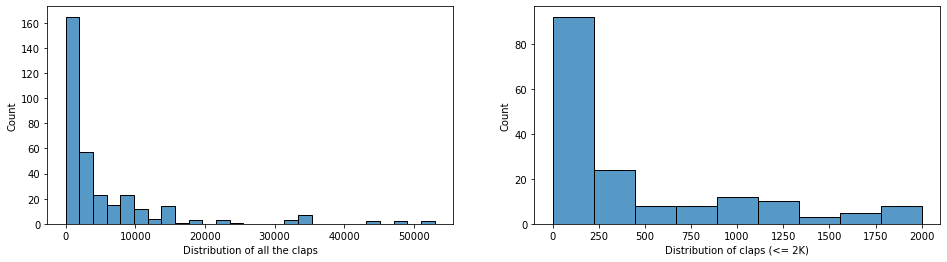

In [15]:
# Distribution of claps in our data
def display_histplot_for_claps(df, claps_threshold=2_000):
    claps_threshold_str = CustomFormatter.format_likes_number_to_str(claps_threshold)
    
    f, axs = plt.subplots(1, 2, figsize=(16, 4))

    sns.histplot(x=df.claps, kde=False, ax=axs[0])
    sns.histplot(x=df[df.claps <= claps_threshold].claps, kde=False, ax=axs[1])

    axs[0].set_xlabel('Distribution of all the claps')
    axs[1].set_xlabel(f'Distribution of claps (<= {claps_threshold_str})')

    # percentage of claps less than equal to claps_threshold
    pct_of_clap = round(len(df[df.claps <= claps_threshold]) / len(df), 2) * 100

    print(f' {pct_of_clap}% of articles have less than eqaul to {claps_threshold_str} 👏 claps')

display_histplot_for_claps(df)

The above `distribution plots` shows that there are some outliers in claps column.

<AxesSubplot:xlabel='claps'>

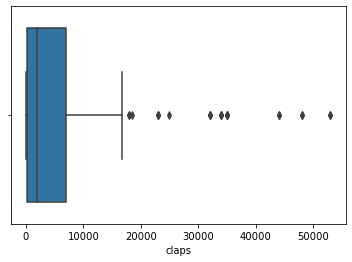

In [16]:
sns.boxplot(x=df.claps) 

The `claps` greater than `15K` are the `outliers` as they are not included in the box of other observation i.e no where near the `quartiles`.

To know more about `detecting and removing outliers` read the following [post](https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba).

<AxesSubplot:xlabel='claps'>

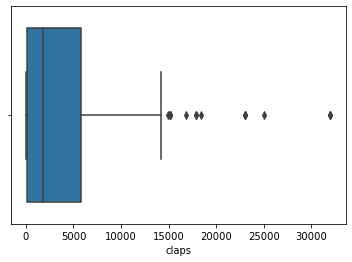

In [17]:
# ### Removing outliers using Z score ###

# getting zscores of all the claps
claps_zscores = np.abs(zscore(df.claps))

# keeping the threshold of 3 (above which a clap will be an outlier)
# instead of 3, -3 can also be kept as threshold & in this case claps below -3 will be an outlier
clap_outliers_row_idx = np.where(claps_zscores > 3)[0].tolist()

# removing outliers
df.drop(clap_outliers_row_idx, axis='rows', inplace=True)

sns.boxplot(x=df.claps)

IQR for claps: 5678.0


<AxesSubplot:xlabel='claps'>

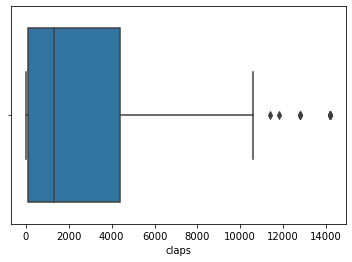

In [18]:
# ### Removing outliers using IQR ###

claps_q1 = df.claps.quantile(0.25)
claps_q3 = df.claps.quantile(0.75)
iqr = claps_q3 - claps_q1
print(f'IQR for claps: {iqr}')

clap_outliers_row_idx = df.claps[(df.claps < (claps_q1 - 1.5 * iqr)) | (df.claps > (claps_q3 + 1.5 * iqr))].index.tolist()

# removing outliers
df.drop(clap_outliers_row_idx, axis='rows', inplace=True)

sns.boxplot(x=df.claps)

In [19]:
# Helper functions to remove outliers


# Using IQR method
def rm_outliers_in_col_using_iqr(df, col, inplace=False):
    Q1 = col.quantile(0.25)
    Q3 = col.quantile(0.75)
    IQR = Q3 - Q1
    print(f'IQR: {IQR}')
    outliers_row_idx = col[(col < (Q1 - 1.5 * IQR)) | (col > (Q3 + 1.5 * IQR))].index.tolist()
    return df.drop(outliers_row_idx, axis='rows', inplace=inplace)


# Using the Zscore method
def rm_outliers_in_col_using_zscore(df, col, inplace=False, threshold=3):
    zscores = np.abs(zscore(col))
    outliers_row_idx = np.where(zscores > threshold)[0].tolist()
    return df.drop(outliers_row_idx, axis='rows', inplace=inplace)

IQR: 4296.5
IQR: 3815.25
IQR: 3836.5
IQR: 3836.5
IQR: 3836.5
IQR: 3836.5
IQR: 3836.5
IQR: 3836.5
IQR: 3836.5
IQR: 3836.5


<AxesSubplot:xlabel='claps'>

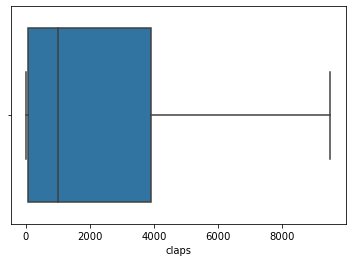

In [20]:
# removing remaining outliers 
for _ in range(10):
    rm_outliers_in_col_using_iqr(df, df.claps, inplace=True)

sns.boxplot(x=df.claps)
    
# removing the outliers for claps column multiple time reason `maybe` that 
# majority of the claps are less 3K and the outliers were spread very far

The average reading ⏰ time of an article is 9.19mins


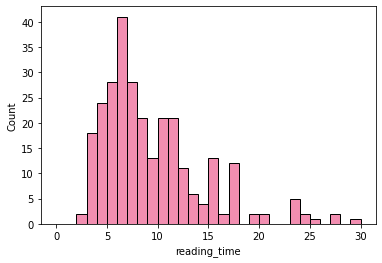

In [21]:
# distribution of reading_time in our data
def display_histplot_for_reading_time(df):
    sns.histplot(
        x=df.reading_time, 
        kde=False, bins=range(df.reading_time.max()), 
        color='#e61e64', alpha=.5
    )
    
    avg_reading_time = round(df.reading_time.mean(), 2)
    print(f'The average reading ⏰ time of an article is {avg_reading_time}mins')


display_histplot_for_reading_time(df)

<AxesSubplot:xlabel='reading_time'>

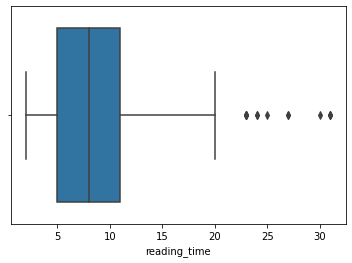

In [22]:
sns.boxplot(x=df.reading_time)

IQR: 6.0


<AxesSubplot:xlabel='reading_time'>

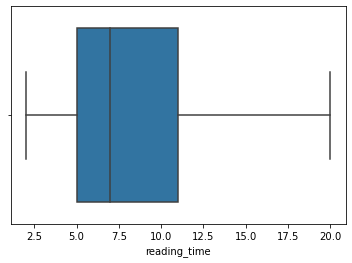

In [23]:
# removing outliers in reading_time column
rm_outliers_in_col_using_iqr(df, df.reading_time, inplace=True)
sns.boxplot(x=df.reading_time)

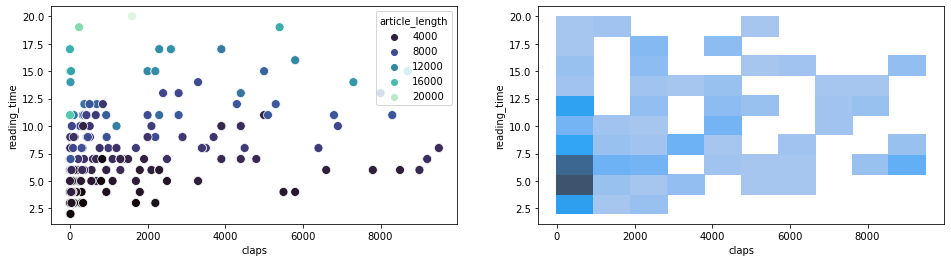

In [24]:
def display_claps_and_reading_time(df):
    f, axs = plt.subplots(1, 2, figsize=(16, 4))

    sns.scatterplot(
        x='claps', y='reading_time', hue='article_length', data=df, 
        palette='mako', s=80, ax=axs[0]
    )
    sns.histplot(
        x='claps', y='reading_time', data=df, 
        palette='mako', ax=axs[1]
    )


display_claps_and_reading_time(df)
    
# Articles whose reading_time is more than 12.5mins won't get much claps

In [25]:
df[['claps', 'reading_time']].corr() # pearson corr == 0.28...

,claps,reading_time
claps,1.000000,0.284287
reading_time,0.284287,1.000000


`claps` & `reading_time` have a `negligible correlation` i.e. they are not correlated.

Color functions to use different colours for `wordcloud` text.

In [26]:
def wc_blue_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(214, 67%%, %d%%)" % randint(60, 100)

def wc_grey_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(0, 0%%, %d%%)" % randint(60, 100)

def wc_green_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(123, 34%%, %d%%)" % randint(50, 100)

def wc_red_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(23, 54%%, %d%%)" % randint(50, 100)

**Plotting wordclouds**

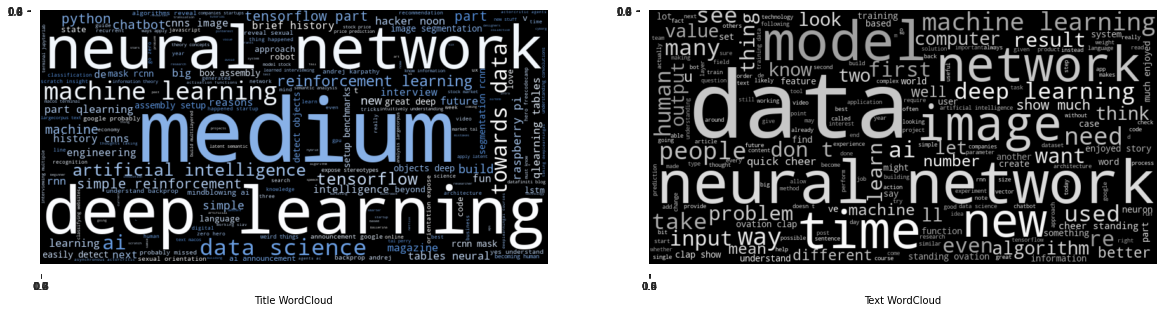

In [27]:
# stopwords for wordcloud
def get_wc_stopwords():
    wc_stopwords = set(STOPWORDS)

    # Adding words to stopwords 
    # these words showed up while plotting wordcloud for text
    wc_stopwords.add('s')
    wc_stopwords.add('one')
    wc_stopwords.add('using')
    wc_stopwords.add('example')
    wc_stopwords.add('work')
    wc_stopwords.add('use')
    wc_stopwords.add('make')
    
    return wc_stopwords


# get title mega str (combined str of all titles)
def get_title_combined_str(df):
    title_words = []
    for title in df.title.values:
        title_words.extend(title.split())
    return ' '.join(title_words)


# get text mega str (combined str of all text)
def get_text_combined_str(df):
    text_words = []
    for text in df.text.values:
        text_words.extend(text.split())
    return ' '.join(text_words)


# plot wordcloud
def plot_wordcloud_for_title_and_text(title_wc, text_wc, title_color_func, text_color_func):
    f, axs = plt.subplots(1, 2, figsize=(20, 10))
    
    with sns.axes_style("ticks"):
        sns.despine(offset=10, trim=True)

        if not title_color_func:
            # default color
            axs[0].imshow(title_wc, interpolation="bilinear")
            axs[0].set_xlabel('Title WordCloud')
        else:
            # customized color
            axs[0].imshow(title_wc.recolor(color_func=title_color_func, random_state=0), interpolation="bilinear")
            axs[0].set_xlabel('Title WordCloud')
            
        if not title_color_func:
            axs[1].imshow(text_wc, interpolation="bilinear")
            axs[1].set_xlabel('Text WordCloud')
        else:
            axs[1].imshow(text_wc.recolor(color_func=text_color_func, random_state=0), interpolation="bilinear")
            axs[1].set_xlabel('Text WordCloud')

            
# display wordcloud
def wordcloud_for_title_and_text(df, title_color_func=None, text_color_func=None):
    # This str will be used to create wordclouds for title & text
    title_str = get_title_combined_str(df)
    text_str = get_text_combined_str(df)
        
    wc_stopwords = get_wc_stopwords()

    title_wc = WordCloud(stopwords=wc_stopwords, width=800, height=400, random_state=0).generate(title_str)
    text_wc = WordCloud(stopwords=wc_stopwords, width=800, height=400, random_state=0).generate(text_str)
    
    plot_wordcloud_for_title_and_text(title_wc, text_wc, title_color_func, text_color_func)
        
        
wordcloud_for_title_and_text(df, wc_blue_color_func, wc_grey_color_func)

`WordInfo` class will help us to `encapsulate` info about a `words` and will contain helper functions to work with `text` & `title` columns. Basically `WordInfo` class will act as `tokenizer` but is slightly customized as per my needs.

In [28]:
class WordInfo:
    def __init__(self, word, domain, reading_time):
        self.word = word
        self.count = 1
        self.reading_time = reading_time
        
        self.domains = set()  # domains in which it appeared
        self.domains.add(domain)

        
    def increment(self, domain, reading_time):
        self.count += 1
        self.domains.add(domain)
        self.reading_time += reading_time
        
        
    def info(self):
        print(f'Word: {self.word}')
        print(f'Count: {self.count}')
        print(f'Domains: {list(self.domains)}')
        print(f'Reading time: {self.reading_time}mins')
        
        
    @staticmethod
    def exists(word, dictionary):
        return dictionary[word] if word in dictionary.keys() else False
    
    
    @staticmethod
    def increment_or_create(dictionary, word, domain, reading_time):
        if word not in stopwords.words('english'):
            obj = WordInfo.exists(word, dictionary)
            if not obj:
                dictionary[word] = WordInfo(word, domain, reading_time)
            else:
                obj.increment(domain, reading_time)
                
                
    @staticmethod
    def export_count_dict(word_dict):
        _dict = {}
        for wordinfo in list(word_dict.values()):
            _dict[wordinfo.word] = wordinfo.count
        return _dict
    
    
    @staticmethod
    def sort_dict_using_values(_dict):
        # in-place sorting
        words = np.array(list(_dict.keys()))
        counts = np.array(list(_dict.values()))
        
        sorted_idxs = counts.argsort()
        sorted_counts = counts[sorted_idxs]
        new_words_order = words[sorted_idxs]

        # reversing the list (making it from ascending to decending)
        _counts = list(reversed(sorted_counts))
        _words = list(reversed(new_words_order))

        return (_counts, _words)
    
    
    @classmethod
    def word_count_df(cls, _dict):
        word_count_dict = cls.export_count_dict(_dict)
        word_count_sorted = cls.sort_dict_using_values(word_count_dict)

        word_count_df = pd.DataFrame({
            'words': word_count_sorted[1],
            'counts': word_count_sorted[0]
        })

        return word_count_df

Below is an example of how `WordInfo` class will be used to make our `EDA` easy.

In [29]:
# key - words: str
# value - object: WordInfo
WORD_DICT = {}


# To test/see how our WORD_DICT will look 
for word in ['hello', 'world', 'python', 'python', 'tensorflow']:
    WordInfo.increment_or_create(WORD_DICT, word, 'deeplearning.io', 24)
        
print(WORD_DICT)

for obj in WORD_DICT.values():
    print()
    obj.info()

{'hello': <__main__.WordInfo object at 0x7f3b1b49d0d0>, 'world': <__main__.WordInfo object at 0x7f3b10f1d550>, 'python': <__main__.WordInfo object at 0x7f3b111b0d90>, 'tensorflow': <__main__.WordInfo object at 0x7f3b10e451d0>}

Word: hello
Count: 1
Domains: ['deeplearning.io']
Reading time: 24mins

Word: world
Count: 1
Domains: ['deeplearning.io']
Reading time: 24mins

Word: python
Count: 2
Domains: ['deeplearning.io']
Reading time: 48mins

Word: tensorflow
Count: 1
Domains: ['deeplearning.io']
Reading time: 24mins


Extracting information about `words` in `title` and `text` columns in `df`.

In [30]:
def get_title_and_text_word_dict(df):
    title_word_dict = {}
    text_word_dict = {}
    
    for domain, title, text, reading_time in df[['domain', 'title', 'text', 'reading_time']].values:
        for word_in_title in title.split():
            WordInfo.increment_or_create(title_word_dict, word_in_title, domain, reading_time)
        for word_in_text in text.split():
            WordInfo.increment_or_create(text_word_dict, word_in_text, domain, reading_time)
            
    return (title_word_dict, text_word_dict)


title_word_dict, text_word_dict = get_title_and_text_word_dict(df)

title_word_dict['medium'].info()
print()
text_word_dict['medium'].info()
print()
title_word_dict['neural'].info()
print()
text_word_dict['neural'].info()

Word: medium
Count: 73
Domains: ['medium.com']
Reading time: 585mins

Word: medium
Count: 46
Domains: ['howwegettonext.com', 'becominghuman.ai', 'towardsdatascience.com', 'hackernoon.com', 'medium.freecodecamp.org', 'wtfeconomy.com', 'medium.com']
Reading time: 425mins

Word: neural
Count: 40
Domains: ['itnext.io', 'blog.slavv.com', 'towardsdatascience.com', 'blog.statsbot.co', 'chatbotslife.com', 'machinelearnings.co', 'hackernoon.com', 'medium.com', 'blog.datafiniti.co', 'lab.wallarm.com']
Reading time: 288mins

Word: neural
Count: 955
Domains: ['blog.coast.ai', 'itnext.io', 'blog.athelas.com', 'medium.freecodecamp.org', 'blog.insightdatascience.com', 'buzzrobot.com', 'techburst.io', 'gab41.lab41.org', 'news.greylock.com', 'worldofweirdthings.com', 'blog.slavv.com', 'towardsdatascience.com', 'blog.statsbot.co', 'chatbotslife.com', 'blog.datafiniti.co', 'lab.wallarm.com', 'medium.mybridge.co', 'blog.usejournal.com', 'machinelearnings.co', 'hackernoon.com', 'medium.com']
Reading time: 

In [31]:
title_word_count_df = WordInfo.word_count_df(title_word_dict)
text_word_count_df = WordInfo.word_count_df(text_word_dict)

In [32]:
def display_word_count(df, top=5, bottom=5):
    # df here is word_count_df
    
    f, axs = plt.subplots(1, 2, figsize=(16, 4))

    # most used words
    sns.barplot(
        x=df.head(top).words, y=df.head(top).counts, 
        color='#473991', alpha=.9, ax=axs[0]
    )

    # least used words
    sns.barplot(
        x=df.tail(bottom).words, y=df.tail(bottom).counts,
        color='#399188', alpha=.9, ax=axs[1]
    )

    axs[0].set_xlabel('Words')
    axs[0].set_ylabel('Counts')  
    axs[1].set_xlabel('Words')
    axs[1].set_ylabel('Counts')  

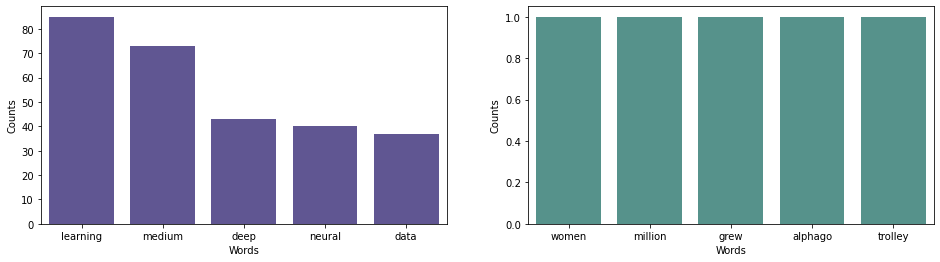

In [33]:
display_word_count(title_word_count_df)

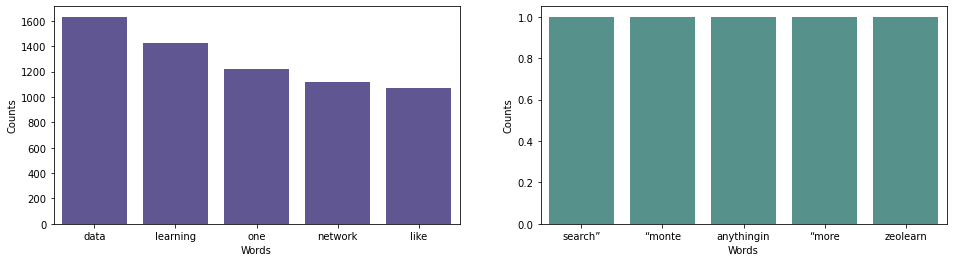

In [34]:
display_word_count(text_word_count_df)

In [35]:
# top 100 articles with respect to claps
top_atricles_wrt_claps = df.sort_values(by='claps', ascending=False).iloc[:100]
top_atricles_wrt_claps.sample(5)

,author,claps,reading_time,link,title,text,domain,article_length
309,Andrej Karpathy,9200,7,https://medium.com/@karpathy/yes-you-should-un...,yes understand backprop andrej karpathy medium,offered csn deep learning class stanford inten...,medium.com,5497
191,Erik Hallström,2500,7,https://medium.com/@erikhallstrm/hello-world-r...,build recurrent neural network tensorflow,tutorial i’ll explain build simple working rec...,medium.com,5750
291,Arthur Juliani,9000,6,https://medium.com/emergent-future/simple-rein...,simple reinforcement learning tensorflow part ...,tutorial reinforcement learning series going e...,medium.com,4972
310,Arthur Juliani,3500,8,https://medium.com/emergent-future/simple-rein...,simple reinforcement learning tensorflow part ...,article want provide tutorial implementing asy...,medium.com,6191
205,Blaise Aguera y Arcas,8700,15,https://medium.com/@blaisea/do-algorithms-reve...,algorithms reveal sexual orientation expose st...,blaise agüera arcas alexander todorov margare...,medium.com,15067


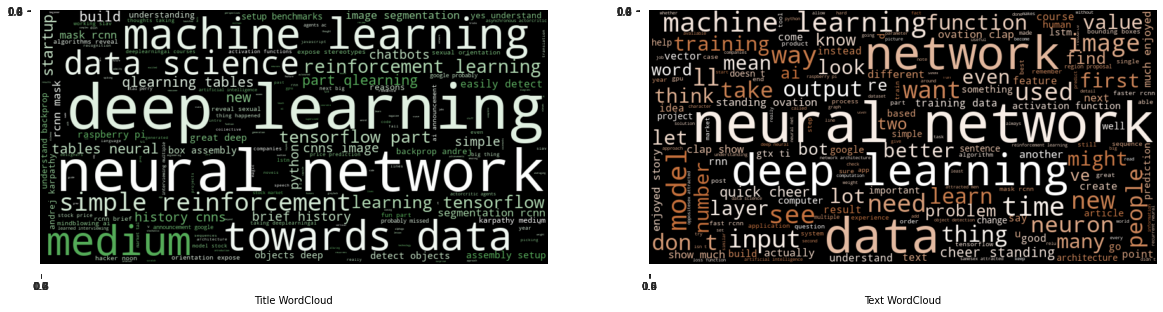

In [36]:
wordcloud_for_title_and_text(top_atricles_wrt_claps, wc_green_color_func, wc_red_color_func)

Most clapped titles & articles includes AI topics

In [37]:
def get_words_count(text):
    info = {} # {word: count}
    for word in text.split():
        if word in info.keys():
            info[word] += 1
        else:
            info[word] = 1
    return info

`AuthorInfo` class will encapsulate different informations about all the `authors`.

In [38]:
class AuthorInfo:
    # this will contains author info 
    authors_df = pd.DataFrame({
        'name': [],
        'total_claps': [],
        'avg_claps': [],
        'total_reading_time': [],
        'avg_reading_time': []
    })
    
    # this will contain author name & domains
    domains_df = pd.DataFrame({
        'authors': [],
        'domains': []
    })
    
    # this will contain words used by authors & their count i.e. how much
    words_df = pd.DataFrame({
        'authors': [],
        'words': [],
        'counts': [],
        'where': []     # title or text (where is the word used)
    })
    
    
    def __init__(self, author_name, author_df):
        # add author info
        AuthorInfo.authors_df = AuthorInfo.authors_df.append({
            'name': author_name,
            'total_claps': author_df.claps.sum(),
            'avg_claps': author_df.claps.mean(),
            'total_reading_time': author_df.reading_time.sum(),
            'avg_reading_time': author_df.reading_time.mean(),
        }, ignore_index=True)
        
        # add author domains
        for domain in author_df.domain.values:
            AuthorInfo.domains_df = AuthorInfo.domains_df.append({
                'authors': author_name,
                'domains': domain
            }, ignore_index=True)
            
        # add word count
        for title, text in author_df[['title', 'text']].values:
            title_info = get_words_count(title)
            text_info = get_words_count(text)
            AuthorInfo.add_wordcount_using_dict(title_info, author_name, 'title')
            AuthorInfo.add_wordcount_using_dict(text_info, author_name, 'text')            
        
        
    @classmethod
    def add_wordcount_using_dict(cls, _dict, author_name, where):
        for word, count in _dict.items(): 
            cls.words_df = cls.words_df.append({
                'authors': author_name,
                'words': word,
                'counts': count,
                'where': where
            }, ignore_index=True)
            
            
    @classmethod
    def get_domains_using_author_name(cls, author_name):
        return AuthorInfo.domains_df[AuthorInfo.domains_df.authors == author_name].domains.unique().tolist()
    
    
    @classmethod
    def get_wordcount_df(cls, author_name, where, ascending=False):
        return cls.words_df[
            # using ['where'] since where is a method of pd.Series
            (cls.words_df.authors == author_name) & (cls.words_df['where'] == where)
        ].sort_values(by='counts', ascending=ascending)
    

    @classmethod
    def reset_df(cls):
        cls.authors_df = pd.DataFrame({
            'name': [],
            'total_claps': [],
            'avg_claps': [],
            'total_reading_time': [],
            'avg_reading_time': []
        })

        cls.domains_df = pd.DataFrame({
            'authors': [],
            'domains': []
        })

        cls.words_df = pd.DataFrame({
            'authors': [],
            'words': [],
            'counts': [],
            'where': []
        })

In [39]:
for author, author_df in top_atricles_wrt_claps.groupby(by='author'):
    AuthorInfo(author, author_df)

In [40]:
AuthorInfo.domains_df.head()

,authors,domains
0,Adam Geitgey,medium.com
1,Adam Geitgey,medium.com
2,Adam Geitgey,medium.com
3,Adam Geitgey,medium.com
4,Aman Dalmia,blog.usejournal.com


In [41]:
AuthorInfo.words_df.head()

,authors,words,counts,where
0,Adam Geitgey,machine,1.0,title
1,Adam Geitgey,learning,2.0,title
2,Adam Geitgey,fun,1.0,title
3,Adam Geitgey,part,1.0,title
4,Adam Geitgey,speech,1.0,title


In [42]:
AuthorInfo.get_wordcount_df('Adam Geitgey', 'title').head(10)

,authors,words,counts,where
635,Adam Geitgey,learning,2.0,title
1971,Adam Geitgey,learning,2.0,title
1269,Adam Geitgey,learning,2.0,title
1,Adam Geitgey,learning,2.0,title
1975,Adam Geitgey,translation,1.0,title
1974,Adam Geitgey,language,1.0,title
1973,Adam Geitgey,part,1.0,title
1972,Adam Geitgey,fun,1.0,title
1272,Adam Geitgey,language,1.0,title
1976,Adam Geitgey,deep,1.0,title


The `words` column in `words_df` of `AuthorInfo` has word appeared in a `title (or text)` & the counts column in word_df of AuthorInfo has number of times the word appeared in a title (or text). So because of that their might be duplicate words in the words columns

But since the counts of some `duplicates` are same so it might hint that there are some duplicate rows in df.

In [43]:
# no duplicates
print(f'Number of duplicate rows: {len(df[df.duplicated()])}')

# checking duplication in author name, title text
print(f"Number of duplicate rows: {len(df[df[['author', 'title', 'text']].duplicated()])}")

# checking where these duplicates differentiate from each other
print(f"Number of duplicate rows: {len(df[df[['author', 'title', 'text', 'claps']].duplicated()])}")
print(f"Number of duplicate rows: {len(df[df[['author', 'title', 'text', 'reading_time']].duplicated()])}")
print(f"Number of duplicate rows: {len(df[df[['author', 'title', 'text', 'link']].duplicated()])}")

# so `link` is the column that differentiate duplicates

Number of duplicate rows: 0
Number of duplicate rows: 75
Number of duplicate rows: 75
Number of duplicate rows: 75
Number of duplicate rows: 0


In [44]:
# duplicate rows

print(f"Number of duplicate titles: {len(df[df[['title']].duplicated()])}")
print(f"Number of duplicate texts: {len(df[df[['text']].duplicated()])}")

def get_duplicate_dfs(df, group_by, how_many=1):
    dfs = []
    
    # considering duplicates on the basis of title & text columns & then grouping them by author
    author_grp = df[df.duplicated(['title', 'text'])].groupby(by=group_by)
    
    for idx, (author, author_df) in enumerate(author_grp):
        if idx <= how_many:
            dfs.append(author_df)
        else:
            return dfs
    
    
# the `duplicated` method on df by default returns all the duplicates `except the first` 
duplicate_sample_df = get_duplicate_dfs(df, group_by='author', how_many=5)

Number of duplicate titles: 76
Number of duplicate texts: 75


In [45]:
def print_links(df):
    for link in df.link.values.tolist():
        print(link)

In [46]:
print_links(duplicate_sample_df[0])
duplicate_sample_df[0]

https://towardsdatascience.com/must-know-information-theory-concepts-in-deep-learning-ai-e54a5da9769d?source=---------7----------------
https://towardsdatascience.com/must-know-information-theory-concepts-in-deep-learning-ai-e54a5da9769d?source=---------3----------------


,author,claps,reading_time,link,title,text,domain,article_length
92,Abhishek Parbhakar,937,6,https://towardsdatascience.com/must-know-infor...,must know information theory concepts deep lea...,information theory important field made signif...,towardsdatascience.com,4182
159,Abhishek Parbhakar,937,6,https://towardsdatascience.com/must-know-infor...,must know information theory concepts deep lea...,information theory important field made signif...,towardsdatascience.com,4182


In [47]:
print_links(duplicate_sample_df[1])
duplicate_sample_df[1]

https://medium.com/@ageitgey/machine-learning-is-fun-part-6-how-to-do-speech-recognition-with-deep-learning-28293c162f7a?source=tag_archive---------6----------------
https://medium.com/@ageitgey/machine-learning-is-fun-part-5-language-translation-with-deep-learning-and-the-magic-of-sequences-2ace0acca0aa?source=tag_archive---------7----------------


,author,claps,reading_time,link,title,text,domain,article_length
138,Adam Geitgey,6800,11,https://medium.com/@ageitgey/machine-learning-...,machine learning fun part speech recognition d...,update article part series check full series p...,medium.com,8757
139,Adam Geitgey,5800,16,https://medium.com/@ageitgey/machine-learning-...,machine learning fun part language translation...,update article part series check full series p...,medium.com,12079


Dropping all the `duplicates` except for the first occurence since `link` column has all unique values even for the duplicates therefore removing the duplicate rows on the basis of `author`, `claps`, `title` & `text`.

In [48]:
df.drop_duplicates(['author', 'claps', 'title', 'text'], ignore_index=True, inplace=True)
len(df) # remaining rows

194

After this `catastrophic` event we can `re-run all of the analysis` to correct all of the `misinterpretation` happened due to these duplicate rows.

It's going to be very easy to re-run all the `analysis` as we have followed the `DRY` principle of programming.

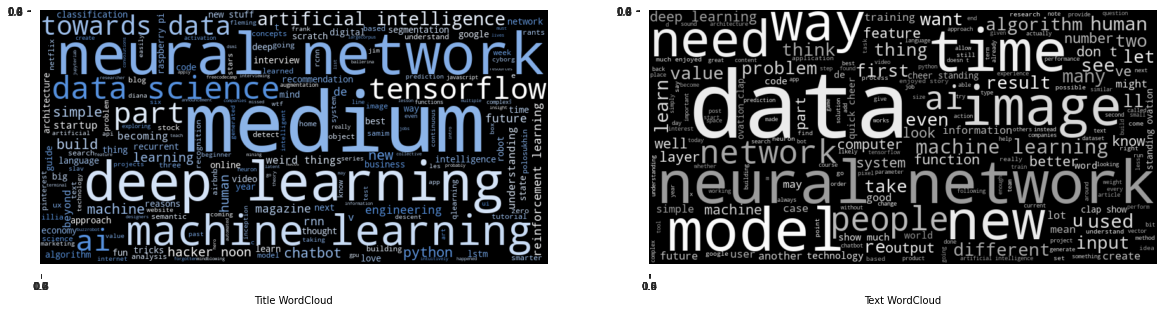

In [49]:
wordcloud_for_title_and_text(df, wc_blue_color_func, wc_grey_color_func)

In [50]:
title_word_dict, text_word_dict = get_title_and_text_word_dict(df)

In [51]:
title_word_count_df = WordInfo.word_count_df(title_word_dict)
text_word_count_df = WordInfo.word_count_df(text_word_dict)

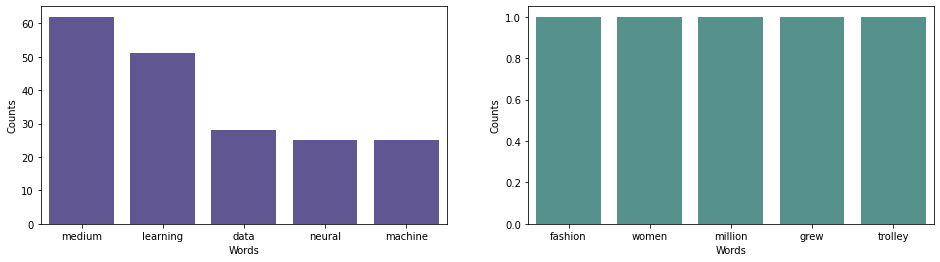

In [52]:
display_word_count(title_word_count_df)

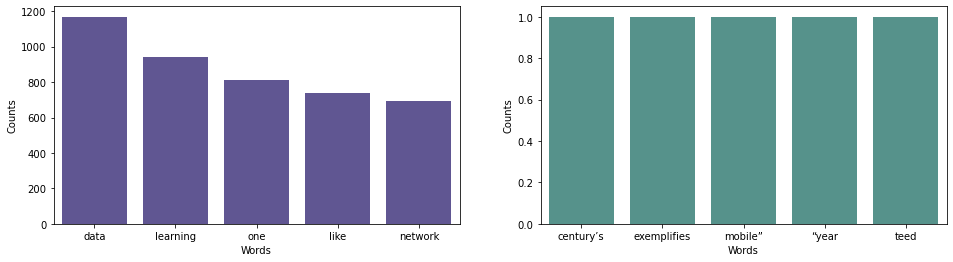

In [53]:
display_word_count(text_word_count_df)

In [54]:
df[['claps', 'reading_time']].corr() 

,claps,reading_time
claps,1.000000,0.326642
reading_time,0.326642,1.000000


the corr increased from `0.28 to 0.32`, but it is still a `low positive correlation` so claps and reading_time have a `very low positive correlation`.

The average reading ⏰ time of an article is 7.75mins


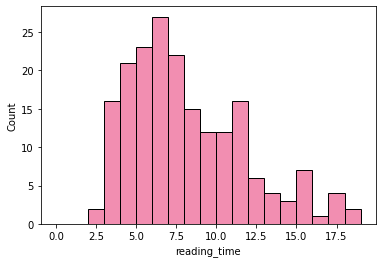

In [55]:
display_histplot_for_reading_time(df)

**Top 100 articles with respect to claps**

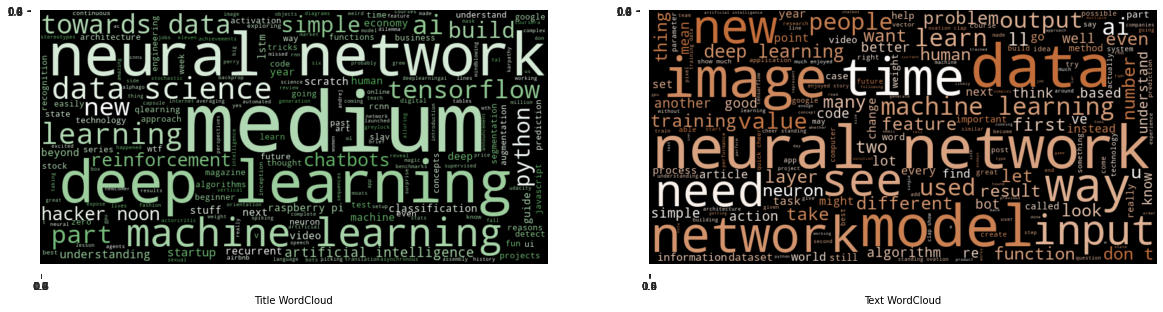

In [56]:
top_atricles_wrt_claps = df.sort_values(by='claps', ascending=False).iloc[:100]
top_atricles_wrt_claps.sample(5)
wordcloud_for_title_and_text(top_atricles_wrt_claps, wc_green_color_func, wc_red_color_func)

`Resetting` the author infos with data (with `no duplicates`).

In [57]:
AuthorInfo.reset_df()

for author, author_df in top_atricles_wrt_claps.groupby(by='author'):
    AuthorInfo(author, author_df)

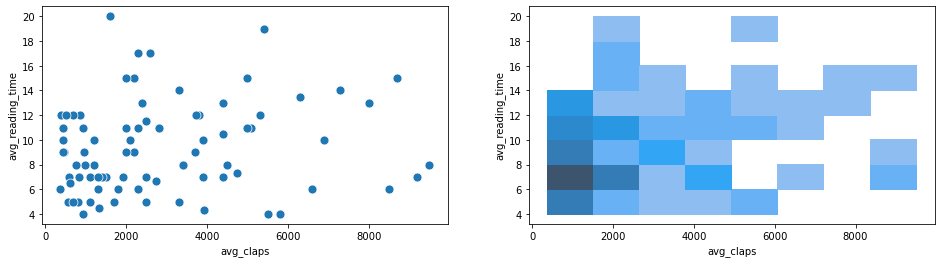

In [58]:
def display_avg_claps_and_avg_reading_time(df):
    f, axs = plt.subplots(1, 2, figsize=(16, 4))

    sns.scatterplot(
        x='avg_claps', y='avg_reading_time', data=df, 
        palette='mako', s=80, ax=axs[0]
    )
    sns.histplot(
        x='avg_claps', y='avg_reading_time', data=df, 
        palette='mako', ax=axs[1]
    )


display_avg_claps_and_avg_reading_time(AuthorInfo.authors_df)
    
# Articles whose reading_time is more than 12mins won't get much claps

In [59]:
def get_top_words(author_name, words_df, where, top_words):
    df = words_df[
        (AuthorInfo.words_df.authors == author_name) & (AuthorInfo.words_df['where'] == where)
    ].sort_values(by='counts', ascending=False).iloc[:top_words].values.tolist()
    
    data = {}
    for _, word, count, _ in df:
        if word in list(data.keys()):
            data[word] += count
        else:
            data[word] = count
            
    return data

    
def get_top_authors_info(authors_df, sort_by, top=5, top_words=5):
    top_author_df = authors_df.sort_values(by=sort_by, ascending=False).iloc[:top]
    df = top_author_df[['name', 'total_claps', 'total_reading_time']]
    
    for author_name, total_claps, total_reading_time in df.values:
        print(f'Author name: {author_name}')
        print(f'Total claps: {total_claps}')
        print(f'Total reading time: {total_reading_time}')
    
        top_words_in_title = get_top_words(author_name, AuthorInfo.words_df, 'title', top_words)
        top_words_in_text = get_top_words(author_name, AuthorInfo.words_df, 'text', top_words)

        print(f'Top words used in title:')
        for word, count  in top_words_in_title.items():
            print(f'\t{word} => {int(count)}x')
        print(f'Top words used in text:')
        for word, count in top_words_in_text.items():
            print(f'\t{word} => {int(count)}x')
    
        print()

**Top 5 authors info with respect to total claps**

In [60]:
get_top_authors_info(AuthorInfo.authors_df, 'total_claps')

Author name: Arthur Juliani
Total claps: 14200.0
Total reading time: 22.0
Top words used in title:
	simple => 1x
	reinforcement => 1x
	qnetworks => 1x
	deep => 1x
	part => 1x
Top words used in text:
	network => 38x
	dqn => 20x
	ac => 15x
	table => 13x

Author name: Adam Geitgey
Total claps: 12600.0
Total reading time: 27.0
Top words used in title:
	learning => 4x
	machine => 1x
	fun => 1x
	part => 1x
Top words used in text:
	translation => 34x
	sound => 29x
	sentence => 26x
	speech => 19x
	part => 18x

Author name: Milo Spencer-Harper
Total claps: 11800.0
Total reading time: 13.0
Top words used in title:
	learning => 2x
	build => 1x
	simple => 1x
	deep => 1x
	network => 1x
Top words used in text:
	neural => 28x
	network => 10x
	neuron => 10x

Author name: Eugenio Culurciello
Total claps: 11400.0
Total reading time: 36.0
Top words used in title:
	fall => 1x
	towards => 2x
	data => 1x
	architectures => 1x
Top words used in text:
	neural => 42x
	network => 33x
	features => 29x
	inception 

**Top 5 authors info with respect to total reading_time**

In [61]:
get_top_authors_info(AuthorInfo.authors_df, 'total_reading_time')

Author name: Slav Ivanov
Total claps: 11200.0
Total reading time: 36.0
Top words used in title:
	reasons => 1x
	assembly => 1x
	learning => 1x
	deep => 1x
	gpu => 1x
Top words used in text:
	gtx => 37x
	gpus => 18x
	get => 17x
	cpu => 16x

Author name: Eugenio Culurciello
Total claps: 11400.0
Total reading time: 36.0
Top words used in title:
	fall => 1x
	towards => 2x
	data => 1x
	architectures => 1x
Top words used in text:
	neural => 42x
	network => 33x
	features => 29x
	inception => 26x
	learning => 26x

Author name: Adam Geitgey
Total claps: 12600.0
Total reading time: 27.0
Top words used in title:
	learning => 4x
	machine => 1x
	fun => 1x
	part => 1x
Top words used in text:
	translation => 34x
	sound => 29x
	sentence => 26x
	speech => 19x
	part => 18x

Author name: Dhruv Parthasarathy
Total claps: 4965.0
Total reading time: 23.0
Top words used in title:
	rcnn => 2x
	brief => 1x
	history => 1x
	cnns => 1x
	image => 1x
Top words used in text:
	rcnn => 54x
	image => 36x
	weights => 20

---

I'll wrap things up there. If you want to find some other answers then go ahead `edit` this kernel. If you have any `questions` then do let me know. 

If this kernel helped you then don't forget to 🔼 `upvote` and share your 🎙 `feedback` on improvements of the kernel.

![](https://media.giphy.com/media/iFU36VwXUd2O43gdcr/giphy.gif)

---